# imports
- I'm going to build a df for training with some selected manufacturers, models, colors
- This dataset was used: https://www.kaggle.com/jonah28/myautoge-cars-data

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import time
import shutil

# params

In [ ]:
# PLEASE PROVIDE THESE TO MAKE THIS NB WORK:

# source path with the images. I used the dataset from the beginning of the NB
path = r'Car_Images\Car_Images' 
# num classes to pull and build an image dataset with
num_classes = 5
# fraction of data used of the original df (the one I had from kaggle was huge)
frac = 0.1 
# original df from car dataset
df_original = pd.read_csv(r'......\MyAuto_ge_Cars_Data.csv')
# number of classed you want to sample from original dataset
n_classes = 5
# number of images in each class
n_images = 10 # just to test the script
# destination path for new image dataset
dest_path='data'
# destination folder for image dataset. Usually you keep dest_path the same and change the 'folder' to make/try different datasets
folder='image dataset 1'

# prep work

In [12]:
# take a sample of original df
df = df_original.loc[:, ['ID', 'Manufacturer', 'Model', 'Color']].sample(frac=frac).reset_index(drop=True)
print(df.shape)
df.head() # most of the rows are folders with images

(8058, 4)


,ID,Manufacturer,Model,Color
0,45640694,SUBARU,Forester,Grey
1,45492670,MERCEDES-BENZ,GL 320 CDI,Black
2,45811555,MERCEDES-BENZ,B 180,Beige
3,45613584,MERCEDES-BENZ,E 350,Grey
4,45814390,HONDA,Insight,Silver


In [13]:
# build a label
df['label'] = df['Manufacturer'] + '_' + df['Model'] + '_' + df['Color']
df = df.loc[:,['ID', 'label']]
df.head()

,ID,label
0,45640694,SUBARU_Forester_Grey
1,45492670,MERCEDES-BENZ_GL 320 CDI_Black
2,45811555,MERCEDES-BENZ_B 180_Beige
3,45613584,MERCEDES-BENZ_E 350_Grey
4,45814390,HONDA_Insight_Silver


In [14]:
# we need to add to our df all file names with full paths
# there are many ways to do this. This might not be the fastest. In fact if there are too many entries it will take quite some time (a few mins)
# take each ID in our df and check what's inside the folder with this ID. If there are photos, we append each photo's path to a list 

start = time.time()

all_paths = []
all_ID = []

for index, ID in enumerate(df.ID):
    try:
        for fname in os.listdir(os.path.join(path, str(df.ID[index]))): # looking inside each folder with corresponding ID
            full_path = os.path.join(path + '\\' + str(ID), fname) # full path for any given image inside the folder
            all_paths.append(full_path)
            all_ID.append(ID)
            
    except FileNotFoundError:
        continue
        

temp_df = pd.DataFrame({'fnames': all_paths, 'ID': all_ID})
print(f'length check: {len(all_paths)}, {len(all_ID)}')
print(f'df shape: {temp_df.shape}')
print(f'df done in {round(time.time()-start)}s')
temp_df.head()

length check: 73742, 73742
df shape: (73742, 2)
df done in 5s


,fnames,ID
0,C:\Users\Oleg\Downloads\_CAR_IMAGES\Car_Images...,45640694
1,C:\Users\Oleg\Downloads\_CAR_IMAGES\Car_Images...,45640694
2,C:\Users\Oleg\Downloads\_CAR_IMAGES\Car_Images...,45640694
3,C:\Users\Oleg\Downloads\_CAR_IMAGES\Car_Images...,45640694
4,C:\Users\Oleg\Downloads\_CAR_IMAGES\Car_Images...,45640694


In [15]:
# build new df from previous and original dataframe, by merging on ID
# this is the df we can work with and feed it to the dataset etc. But there are still too many classes for my liking.
# I want to clean it some more. Specifically, I don't want to have cabin photos or other irrelevant pictures, so I'll remove them manually (or we could do or find another classifier to do that for us, like YOLO and check for cars) 
new_df = temp_df.merge(df, how='left', on='ID').drop('ID', 1).dropna()
print(new_df.shape)
new_df.head()

(72533, 2)


,fnames,label
0,C:\Users\Oleg\Downloads\_CAR_IMAGES\Car_Images...,SUBARU_Forester_Grey
1,C:\Users\Oleg\Downloads\_CAR_IMAGES\Car_Images...,SUBARU_Forester_Grey
2,C:\Users\Oleg\Downloads\_CAR_IMAGES\Car_Images...,SUBARU_Forester_Grey
3,C:\Users\Oleg\Downloads\_CAR_IMAGES\Car_Images...,SUBARU_Forester_Grey
4,C:\Users\Oleg\Downloads\_CAR_IMAGES\Car_Images...,SUBARU_Forester_Grey


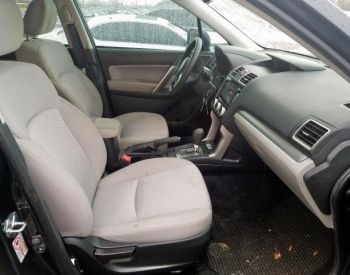

In [16]:
Image.open(new_df.fnames[0])

In [17]:
# classes we will use for training. These are the most populated classes.
# these are the top "num classes"
train_classes = new_df.label.value_counts()[:num_classes].index.tolist()

In [18]:
# final df with needed classes only
# just filter "train_classes"
final_df = new_df.loc[new_df['label'].isin(train_classes)].reset_index(drop=True)
print(f'total classes:', final_df.label.nunique())
print(final_df.shape)
final_df.head()

total classes: 5
(6737, 2)


,fnames,label
0,C:\Users\Oleg\Downloads\_CAR_IMAGES\Car_Images...,TOYOTA_Camry_Black
1,C:\Users\Oleg\Downloads\_CAR_IMAGES\Car_Images...,TOYOTA_Camry_Black
2,C:\Users\Oleg\Downloads\_CAR_IMAGES\Car_Images...,TOYOTA_Camry_Black
3,C:\Users\Oleg\Downloads\_CAR_IMAGES\Car_Images...,TOYOTA_Camry_Black
4,C:\Users\Oleg\Downloads\_CAR_IMAGES\Car_Images...,TOYOTA_Camry_Black


In [19]:
# I'll take a portion of each class to make training faster (will do it on cpu)
final_df.label.value_counts()

TOYOTA_Prius_White           2551
TOYOTA_Camry_Black           1424
MERCEDES-BENZ_E 350_Black    1295
TOYOTA_Camry_White            773
HYUNDAI_Sonata_Silver         694
Name: label, dtype: int64

In [37]:
# this cell make a new image dataset:
# 0. it will use original image dataset and our custom final_df to pull images from it
# 1. it will create n folders = 'n_classes'
# 2. it will put 'n_images' in each folder
# 3. by default it will create create "../data/image dataset 1/--class name--" where class name is one of the class names from n_classes

# there will be an error if you sample more images than there are available for a class
def copy_class_images_to_folders(n_classes, n_images, folder='image dataset 1', dest_path='data', df=final_df):
    
    """purpose of this func is to quickly copy n_images of n_classes to dest_folder
    or, in other words - create n folders (n_classes) with n_images in each.
    After creating such folder it is good idea to rename it or at pass another name to 'folder' variable. Otherwise, it will be deleted and a new one will be created in its place next time you run this function

    Args:
        n_classes ([str or list of str]): [a list with n classes, where n >= 1]
        folder ([str]): [where to create all the class folders and put images. Usually you would change the folder name and keep dest_path the same to create different image datasets]
        dest_path ([str], optional): [destination path. Please provide the folder as well]
        n_images ([int], optional): [number of images to use for building a folder].
        df ([pd.DataFrame]) - [source of paths for images. Defaults to final_df from this NB]
    """

    dest_folder = os.path.join(dest_path, folder)

    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    for clas in n_classes: # itterate over each class and sample n_images for each

        start = time.time()
        print(f'the size of {clas} class: {df[df.label==clas].shape[0]}, sampling {n_images} images')
        temp_df = df[df.label==clas].sample(n=n_images).reset_index(drop=True)
        dest_folder_class = os.path.join(dest_folder, clas)

        if os.path.exists(dest_folder_class): # if folder exists - deletes it
                shutil.rmtree(dest_folder_class)

        if not os.path.exists(dest_folder_class): # if the folder is missing - creates it
                os.makedirs(dest_folder_class)
        
        for idx in range(temp_df[:n_images].shape[0]):

            old_path = temp_df.fnames[idx]
            fname = old_path.split('\\')[-1]
            extension = old_path.split('.')[-1]
            new_path = os.path.join(dest_folder_class, fname)

            if extension != 'jpg':
                continue

            shutil.copy(old_path, new_path)

    print(f'\ncopied all images in {round(time.time()-start)}s')

copy_class_images_to_folders(train_classes, 10)

the size of TOYOTA_Prius_White class: 2551, sampling 10 images
the size of TOYOTA_Camry_Black class: 1424, sampling 10 images
the size of MERCEDES-BENZ_E 350_Black class: 1295, sampling 10 images
the size of TOYOTA_Camry_White class: 773, sampling 10 images
the size of HYUNDAI_Sonata_Silver class: 694, sampling 10 images

copied all images in 0s
